In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")

## Open Data and Save it

In [20]:
trainingdf= pd.read_csv('../preprocessed_data/revisedtrainingdf.csv')
testingdf= pd.read_csv('../preprocessed_data/revisedtestingdf.csv')

X_train=trainingdf.iloc[:, 1:]
y_train=trainingdf.iloc[:,0]
X_test=testingdf.iloc[:,1:]
y_test=testingdf.iloc[:,0]

In [21]:
X_train.columns,  X_test.columns

(Index(['time session', 'PULocationID', 'tip_amount', 'total_amount',
        'avespeed_mileshr', 'day', 'DOLocationID', 'total_trip_duration',
        'tempF', 'date_num'],
       dtype='object'),
 Index(['time session', 'PULocationID', 'tip_amount', 'total_amount',
        'avespeed_mileshr', 'day', 'DOLocationID', 'total_trip_duration',
        'tempF', 'date_num'],
       dtype='object'))

In [22]:
y_train, y_test

(0         low
 1         med
 2        high
 3         low
 4        high
          ... 
 23342     med
 23343     low
 23344     low
 23345     low
 23346     med
 Name: trip demand, Length: 23347, dtype: object,
 0         med
 1         med
 2         low
 3         low
 4        high
          ... 
 11725     med
 11726     low
 11727     low
 11728     low
 11729     med
 Name: trip demand, Length: 11730, dtype: object)

## Baseline Model

The base model is based on an individual randomly assigning whether a specific area has low, medium or high demand where there is a equal chance of picking each level of demand.

Training accuracy is:  0.3307919647063863
Testing accuracy is:  0.33341858482523445


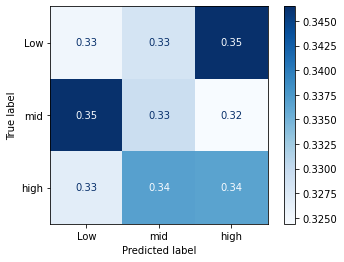

In [23]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
y_pred_training= dummy_clf.predict(X_train)
ac = accuracy_score(y_train,y_pred_training)
print('Training accuracy is: ',ac)
y_pred_base= dummy_clf.predict(X_test)
ac = accuracy_score(y_test,y_pred_base)
print('Testing accuracy is: ',ac)
plot_confusion_matrix(dummy_clf, X_test, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues,  normalize= 'true')

The model has a very low training accuracy and low testing accuracy, indicating that it didn't fit to the training data well. 

In [24]:
print("Baseline Model: ")
print(classification_report(y_test, y_pred_base))

Baseline Model: 
              precision    recall  f1-score   support

        high       0.32      0.34      0.33      3749
         low       0.35      0.34      0.35      4100
         med       0.32      0.32      0.32      3881

    accuracy                           0.33     11730
   macro avg       0.33      0.33      0.33     11730
weighted avg       0.33      0.33      0.33     11730



The results of this is very intuitive. For every level demand,  the model was able to correctly assign  approximately 1/3 and approximately 1/3 of the predicted labels were correct.

## Model 1: Random Forest Classifier

Training accuracy is:  1.0
Testing accuracy is:  0.8485080988917306


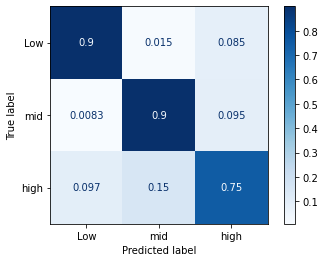

In [25]:
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)
y_pred_training= clf_rf.predict(X_train)
ac = accuracy_score(y_train,y_pred_training)
print('Training accuracy is: ',ac)
y_pred_1= clf_rf.predict(X_test)
ac = accuracy_score(y_test,y_pred_1)
print('Testing accuracy is: ',ac)
plot_confusion_matrix(clf_rf, X_test, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues,
                     normalize= 'true')

This model is clearly better than the baseline model suggesting that the machine learning model is successful. While the training accuracy is extremely high in this case, the testing accuracy is also high. Since overfitting occurs only when training accuracy is high and testing accuracy is low. We can further examine this model.

In [26]:
print("Baseline Mode: ")
print(classification_report(y_test, y_pred_base))
print("Model 1: ")
print(classification_report(y_test, y_pred_1))

Baseline Mode: 
              precision    recall  f1-score   support

        high       0.32      0.34      0.33      3749
         low       0.35      0.34      0.35      4100
         med       0.32      0.32      0.32      3881

    accuracy                           0.33     11730
   macro avg       0.33      0.33      0.33     11730
weighted avg       0.33      0.33      0.33     11730

Model 1: 
              precision    recall  f1-score   support

        high       0.89      0.90      0.90      3749
         low       0.85      0.90      0.87      4100
         med       0.80      0.75      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730



The f1 scores which takes in consideration of precision and recall seems to show very positive results and seems to indicate high precision and recall. This is an obvious improvement from the baseline model.

In [27]:
# Get numerical feature importances
importances = list(clf_rf.feature_importances_)
feature_list= list(X_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: PULocationID         Importance: 0.22
Variable: total_amount         Importance: 0.15
Variable: DOLocationID         Importance: 0.14
Variable: avespeed_mileshr     Importance: 0.13
Variable: tip_amount           Importance: 0.1
Variable: total_trip_duration  Importance: 0.1
Variable: tempF                Importance: 0.05
Variable: time session         Importance: 0.04
Variable: day                  Importance: 0.04
Variable: date_num             Importance: 0.04


[None, None, None, None, None, None, None, None, None, None]

In examining the contribution of the feature to the model, it can be seen that improvement_surcharge doesn't contribute to the model. Hence, we can try a new model where the feature is removed and see the changes.

## Model 3: Random Forest Classifier with Tuned Parameters 

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [15, 17, 20]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto'], 'max_depth': [15, 17, 20, None], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [1, 2, 5]}


In [29]:
rf_random = RandomizedSearchCV(estimator= RandomForestClassifier(random_state=43), param_distributions=random_grid,
                              cv=10, verbose=2,  n_jobs=-1)

# Fit the random search model
print("fitting...")
rf_random.fit(X_train, y_train);

fitting...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [30]:
rf_random.best_params_

{'n_estimators': 733,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [31]:
rf_random.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=733, random_state=43)

Training accuracy is:  0.9892063220113934
Testing accuracy is:  0.8485080988917306


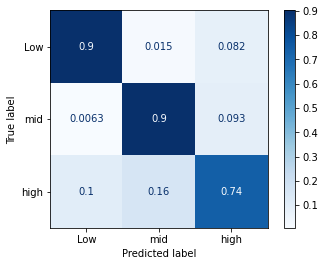

In [32]:
clf_rf_3 = RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=733, random_state=43)  
clr_rf_3 = clf_rf_3.fit(X_train, y_train)
y_pred_3= clf_rf_3.predict(X_train)
ac = accuracy_score(y_train,y_pred_3)
print('Training accuracy is: ',ac)
y_pred_3= clf_rf_3.predict(X_test)
ac = accuracy_score(y_test, y_pred_3)
print('Testing accuracy is: ', ac)

plot_confusion_matrix(clf_rf_3, X_test, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues,  normalize= 'true')

The fitting accuracy decreased by 0.011% as well.

In [35]:
print("Model 1:\n", classification_report(y_test, y_pred_1))
print("Model 2:\n", classification_report(y_test, y_pred_3))

Model 1:
               precision    recall  f1-score   support

        high       0.89      0.90      0.90      3749
         low       0.85      0.90      0.87      4100
         med       0.80      0.75      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730

Model 2:
               precision    recall  f1-score   support

        high       0.89      0.90      0.90      3749
         low       0.85      0.90      0.87      4100
         med       0.81      0.74      0.77      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730



The f1 scores is better by one percent in classing low demand.

In [34]:
# Get numerical feature importances
importances = list(clf_rf_3.feature_importances_)
feature_list= list(X_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: PULocationID         Importance: 0.23
Variable: total_amount         Importance: 0.16
Variable: DOLocationID         Importance: 0.15
Variable: avespeed_mileshr     Importance: 0.13
Variable: tip_amount           Importance: 0.1
Variable: total_trip_duration  Importance: 0.1
Variable: time session         Importance: 0.04
Variable: tempF                Importance: 0.04
Variable: day                  Importance: 0.03
Variable: date_num             Importance: 0.03


[None, None, None, None, None, None, None, None, None, None]

[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=377; total time=  34.7s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=377; total time=  27.2s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=377; total time=  31.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=466; total time=  42.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=466; total time=  40.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time= 1.0min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time= 1.1min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time= 1.1min
[CV] END max_depth=17, max_f

[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=377; total time=  35.0s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=377; total time=  27.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=466; total time=  42.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=466; total time=  43.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=466; total time=  38.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time= 1.1min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time= 1.1min
[CV] END max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=644; total time=  53.4s
[CV] END max_depth=17, max_

Since there is a slightest improvement in model 2 compared to model 1, this model will be considered the best model so far

## Final Model 
Through fitting, we accepted Model 2 as the final model with the following estimator:

RandomForestClassifier(min_samples_split=5, n_estimators=911, random_state=43) 

Features: PULocationID, total_amount, DOLocationID,avespeed_mileshr, total_trip_duration, tip_amount, tempF, time session, day, date_num